## Step 1: Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
from torchvision import models
from PIL import Image
import cv2
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns



 | Libraries     | Uses |
|----------|-----|
| import torch    | Core PyTorch functionality (tensors, autograd, etc.) |
| import torch.nn as nn  |   Build neural network layers (Conv2d, ReLU, etc.)|
| import torch.optim as optim   | Optimizers like SGD, Adam|
| from torch.utils.data import DataLoader, Dataset  | Efficient data loading and custom dataset creation |
| import torchvision           |     Computer vision library with datasets/models/transforms |
| import torchvision.transforms as transforms  | Image transformations (resize, normalize, etc.) |
| import torchvision.datasets as datasets       | Common image datasets (CIFAR10, MNIST, etc.) |
| from torchvision import models    | Pretrained models like ResNet, VGG |
| from PIL import Image             | Open and manipulate image files (rotate, convert, resize) |
| import cv2   |   Advanced image processing (filters, edge detection, etc.) |
| import numpy as np    | Numerical operations and array manipulations |

## Step 2: Setting Device

In [ ]:
# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 3: Defining Transformations

In [ ]:
# Transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # For grayscale
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

## Setp 4: Loading Dataset

### Mounting Drive

In [ ]:
drive.mount('/content/drive')

NameError: name 'drive' is not defined

### Setting Base Path

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/Xray/chest_xray'
print(os.listdir(base_path))

['train', 'val', 'test']


In [ ]:
# Subfolders
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')

In [ ]:
# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=transform['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
print(" Classes:", train_dataset.classes)

 Classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")
print(f"Labels: {labels}")

Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1])


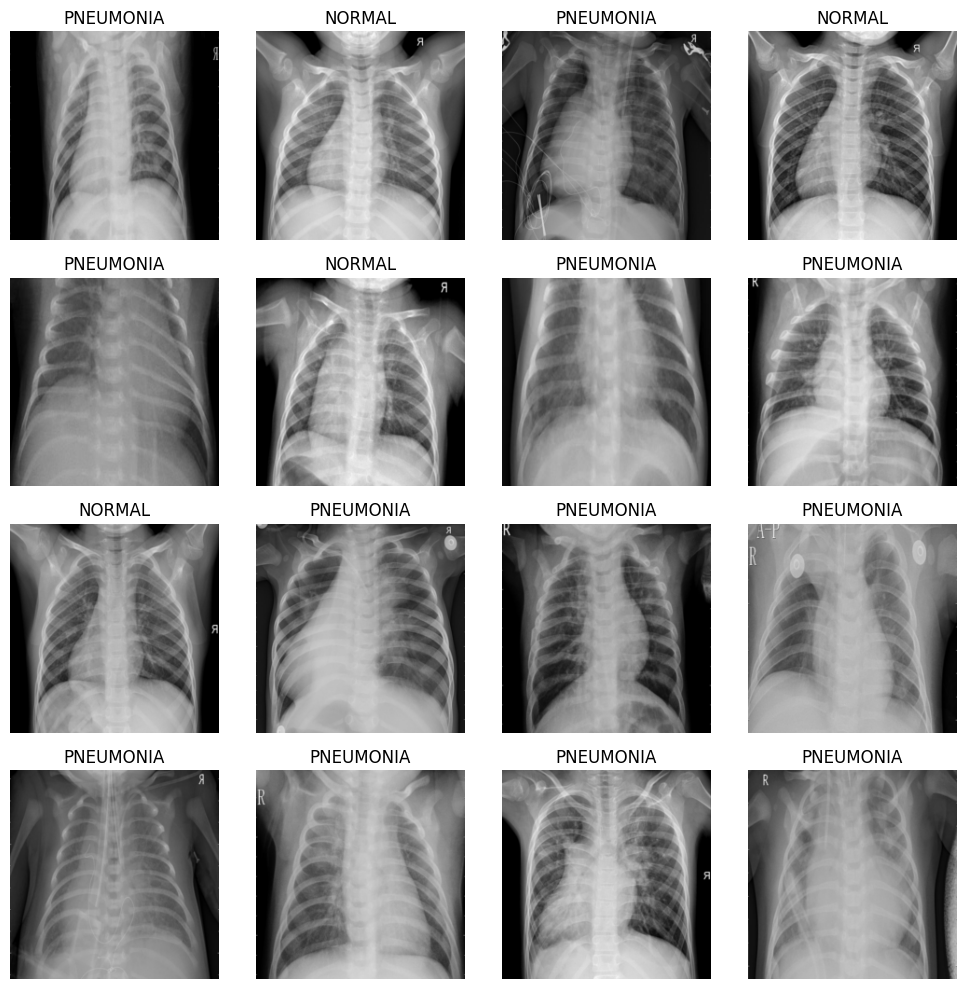

In [ ]:
# Mapping from class index to class name
class_names = train_dataset.classes  # ['NORMAL', 'PNEUMONIA']

def imshow_with_labels(images, labels, class_names):
    # Unnormalize
    images = images / 2 + 0.5
    np_images = images.numpy()

    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        img = np.transpose(np_images[i], (1, 2, 0))
        plt.imshow(img)
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow_with_labels(images[:16], labels[:16], class_names)


In [ ]:
# Simple CNN Model
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, input_size=(3, 224, 224)):
        super(SimpleCNN, self).__init__()

        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),   # 224 -> 112
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),  # 112 -> 56
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)  # 56 -> 28
        )

        # Automatically calculate flatten size
        self._initialize_flatten_size(input_size)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def _initialize_flatten_size(self, input_size):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)  # e.g., (1, 3, 224, 224)
            features_output = self.features(dummy_input)
            self.flattened_size = features_output.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
model = SimpleCNN(input_size=(3, 224, 224)).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    print(f"Validation Accuracy: {100*val_correct/val_total:.2f}%")


Epoch 1, Loss: 0.2245, Accuracy: 90.43%
Validation Accuracy: 81.25%
Epoch 2, Loss: 0.1179, Accuracy: 95.64%
Validation Accuracy: 75.00%
Epoch 3, Loss: 0.0938, Accuracy: 96.54%
Validation Accuracy: 81.25%
Epoch 4, Loss: 0.0901, Accuracy: 96.76%
Validation Accuracy: 87.50%
Epoch 5, Loss: 0.0846, Accuracy: 97.07%
Validation Accuracy: 75.00%
Epoch 6, Loss: 0.0745, Accuracy: 97.65%
Validation Accuracy: 81.25%
Epoch 7, Loss: 0.0760, Accuracy: 97.42%
Validation Accuracy: 93.75%
Epoch 8, Loss: 0.0657, Accuracy: 97.82%
Validation Accuracy: 87.50%
Epoch 9, Loss: 0.0475, Accuracy: 98.26%
Validation Accuracy: 93.75%
Epoch 10, Loss: 0.0568, Accuracy: 97.97%
Validation Accuracy: 81.25%


In [ ]:
model.eval()
test_correct, test_total = 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(f"Test Accuracy: {100*test_correct/test_total:.2f}%")

Test Accuracy: 73.08%


Accuracy: 0.7308
Precision: 0.6996
Recall: 0.9974
F1-Score: 0.8224


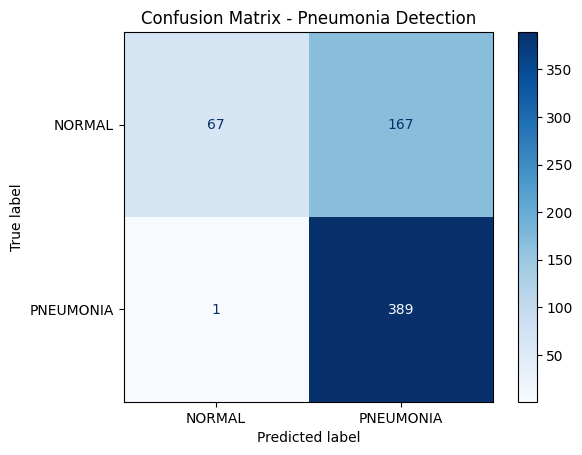

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}")

# Precision
prec = precision_score(all_labels, all_preds)
print(f"Precision: {prec:.4f}")

# Recall
rec = recall_score(all_labels, all_preds)
print(f"Recall: {rec:.4f}")

# F1-Score
f1 = f1_score(all_labels, all_preds)
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Pneumonia Detection")
plt.show()